In [2]:
# 1. Імпорт бібліотек
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split

In [3]:
# 2. Підготовка даних
data_dir = './dataset'
train_dir = os.path.join(data_dir, 'seg_train')
test_dir = os.path.join(data_dir, 'seg_test')
pred_dir = os.path.join(data_dir, 'seg_pred')

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class_names = full_train_dataset.classes
num_classes = len(class_names)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 3. SimpleCNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model_cnn = SimpleCNN(num_classes).to(device)

In [ ]:
# 4. ResNet18 Transfer Learning
model_resnet = models.resnet18(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad = False
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, num_classes)
model_resnet = model_resnet.to(device)

In [6]:
# 5. Тренувальна функція з логами
def train_model(model, optimizer, scheduler, num_epochs=10, name="Model"):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            dataloader = train_loader if phase == 'train' else val_loader
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f"{name}_best_model.pt")
    print(f"Best val Acc for {name}: {best_acc:.4f}, model saved.")
    return model, history

In [7]:
# 6. Оцінка
def evaluate(model, dataloader, name="Model"):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n Evaluation Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return acc, f1

In [8]:
# 7. Навчання обох моделей
print("\n=== Training SimpleCNN ===")
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)
model_cnn, hist_cnn = train_model(model_cnn, optimizer_cnn, scheduler_cnn, name="SimpleCNN")

print("\n=== Training ResNet18 ===")
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001)
scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)
model_resnet, hist_resnet = train_model(model_resnet, optimizer_resnet, scheduler_resnet, name="ResNet18")


=== Training SimpleCNN ===
Epoch 1/10
----------
train Loss: 1.0221 Acc: 0.6186
val Loss: 0.7231 Acc: 0.7413
Epoch 2/10
----------
train Loss: 0.7000 Acc: 0.7499
val Loss: 0.5420 Acc: 0.8122
Epoch 3/10
----------
train Loss: 0.5770 Acc: 0.7937
val Loss: 0.5172 Acc: 0.8186
Epoch 4/10
----------
train Loss: 0.4907 Acc: 0.8276
val Loss: 0.4631 Acc: 0.8396
Epoch 5/10
----------
train Loss: 0.4177 Acc: 0.8557
val Loss: 0.4711 Acc: 0.8396
Epoch 6/10
----------
train Loss: 0.3552 Acc: 0.8733
val Loss: 0.4833 Acc: 0.8393
Epoch 7/10
----------
train Loss: 0.2973 Acc: 0.8994
val Loss: 0.4866 Acc: 0.8471
Epoch 8/10
----------
train Loss: 0.1931 Acc: 0.9342
val Loss: 0.4568 Acc: 0.8571
Epoch 9/10
----------
train Loss: 0.1638 Acc: 0.9467
val Loss: 0.4511 Acc: 0.8599
Epoch 10/10
----------
train Loss: 0.1514 Acc: 0.9499
val Loss: 0.4499 Acc: 0.8617
Best val Acc for SimpleCNN: 0.8617, model saved.

=== Training ResNet18 ===
Epoch 1/10
----------
train Loss: 0.5058 Acc: 0.8374
val Loss: 0.2902 Acc: 


 Evaluation Report for SimpleCNN:
              precision    recall  f1-score   support

   buildings       0.84      0.85      0.85       437
      forest       0.96      0.97      0.96       474
     glacier       0.87      0.79      0.83       553
    mountain       0.79      0.84      0.82       525
         sea       0.88      0.90      0.89       510
      street       0.89      0.88      0.88       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



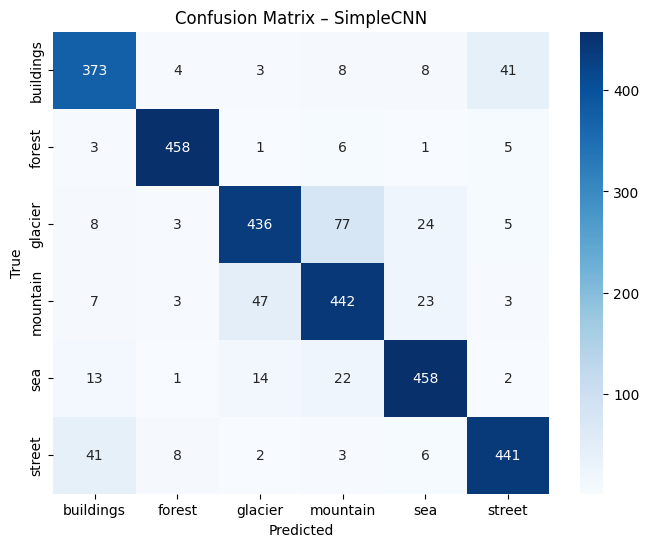


 Evaluation Report for ResNet18:
              precision    recall  f1-score   support

   buildings       0.90      0.91      0.90       437
      forest       0.98      0.99      0.99       474
     glacier       0.85      0.85      0.85       553
    mountain       0.86      0.82      0.84       525
         sea       0.94      0.96      0.95       510
      street       0.92      0.91      0.92       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



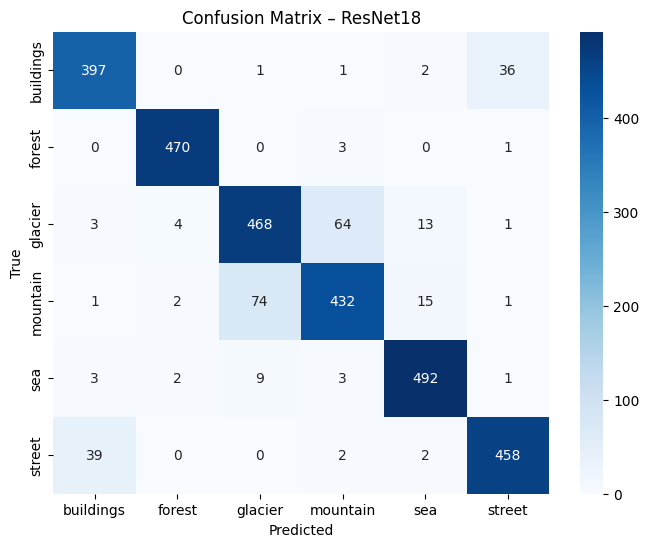

In [9]:
# 8. Оцінка
acc_cnn, f1_cnn = evaluate(model_cnn, test_loader, name="SimpleCNN")
acc_resnet, f1_resnet = evaluate(model_resnet, test_loader, name="ResNet18")

In [10]:
# 9. Порівняльна таблиця
results = pd.DataFrame({
    "Model": ["SimpleCNN", "ResNet18"],
    "Accuracy": [acc_cnn, acc_resnet],
    "F1-Score": [f1_cnn, f1_resnet]
})

print("\n Порівняння ефективності моделей:")
print(results.to_string(index=False))


 Порівняння ефективності моделей:
    Model  Accuracy  F1-Score
SimpleCNN  0.869333  0.869223
 ResNet18  0.905667  0.905281


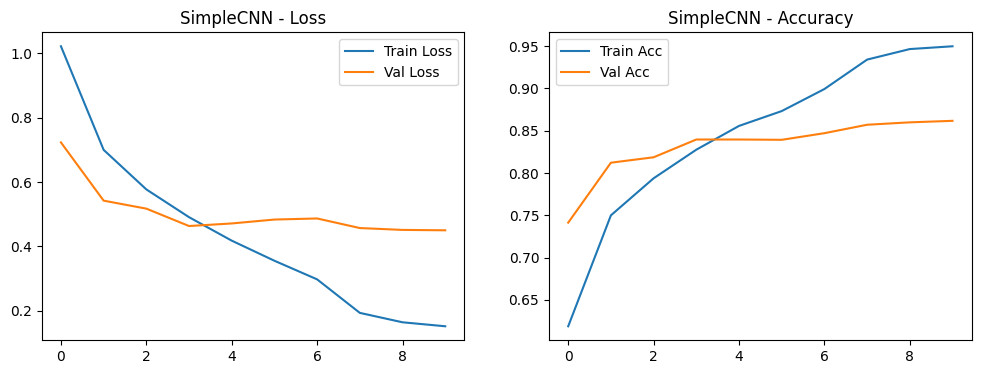

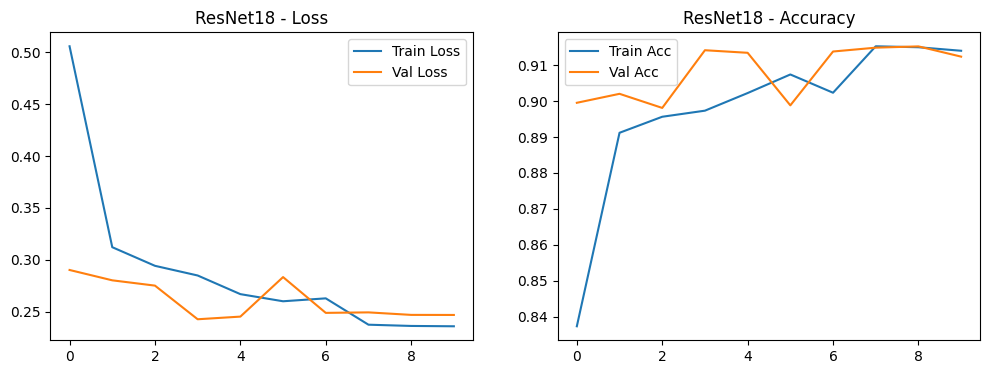

In [11]:
# 10. Графік навчання
def plot_training(history, name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{name} - Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{name} - Accuracy')
    plt.legend()
    plt.show()

plot_training(hist_cnn, "SimpleCNN")
plot_training(hist_resnet, "ResNet18")

In [12]:
# 11. Прогноз на власні зображення
pred_transforms = val_test_transforms

def predict_images(model, pred_dir, model_name="Model"):
    model.eval()
    print(f"\n🔍 Прогноз для зображень з '{pred_dir}' ({model_name})")
    for img_name in os.listdir(pred_dir):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(pred_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        img_tensor = pred_transforms(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)
        
        predicted_class = class_names[pred.item()]
        plt.imshow(image)
        plt.title(f"{img_name} → {predicted_class}")
        plt.axis('off')
        plt.show()

In [ ]:
# Обираємо найбільш ефективну модель, з якою хочемо передбачати:
predict_images(model_resnet, pred_dir, model_name="ResNet18")
# predict_images(model_cnn, pred_dir, model_name="SimpleCNN")